In [19]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import os
from dotenv import load_dotenv

os.chdir("/Users/yshmbid/Documents/home/github/SQL")  # set path
load_dotenv() 

True

In [20]:
# 1. CSV 불러오기 및 임베딩 생성
# 데이터 불러오기
df = pd.read_csv("github_issues_large.csv")  # issueId, title, description, tags 포함

# 임베딩 모델 로드
model = SentenceTransformer("all-MiniLM-L6-v2")

# title + description을 합쳐서 임베딩 생성
df["text"] = df["title"].astype(str) + " " + df["description"].astype(str)
df["embedding"] = df["text"].apply(lambda x: model.encode(x).tolist())
df

,issue_id,title,description,tags,text,embedding
0,1001,Permission bug,Report generation fails due to timeout.,"image,security,auth,sync",Permission bug Report generation fails due to ...,"[0.002779127098619938, 0.07162576913833618, -0..."
1,1002,Email not sent,API responses are delayed under heavy traffic.,"backend,ui,search,upload",Email not sent API responses are delayed under...,"[-0.015433772467076778, -0.03188401088118553, ..."
2,1003,Double click crash,API responses are delayed under heavy traffic.,"backend,upload,security,ux",Double click crash API responses are delayed u...,"[-0.02558872289955616, -0.07072505354881287, 0..."
3,1004,Broken image,Report generation fails due to timeout.,"auth,sync,performance",Broken image Report generation fails due to ti...,"[0.012125000357627869, 0.04304826259613037, -0..."
4,1005,Dark mode glitch,Charts fail to render when dataset is empty.,"security,search,frontend",Dark mode glitch Charts fail to render when da...,"[0.056051105260849, -0.04151713848114014, 0.07..."
...,...,...,...,...,...,...
95,1096,Data not syncing,Double clicking crashes the modal window.,"charts,upload",Data not syncing Double clicking crashes the m...,"[0.009910003282129765, -0.08880452811717987, 0..."
96,1097,Chart rendering error,Dark mode causes UI flickering in forms.,"i18n,ui,permissions",Chart rendering error Dark mode causes UI flic...,"[-0.011460007168352604, -0.031226973980665207,..."
97,1098,Double click crash,Dark mode causes UI flickering in forms.,"search,report,sync",Double click crash Dark mode causes UI flicker...,"[-0.03053748793900013, -0.06853213906288147, 0..."
98,1099,Login failure,User permissions are not applied correctly.,"i18n,permissions",Login failure User permissions are not applied...,"[0.08809271454811096, 0.012933161109685898, 0...."


In [ ]:
# 3. Python에서 데이터 적재
import psycopg2
import json

conn = psycopg2.connect(
    host="localhost",
    port=5432,
    database="postgres",
    user="postgres",
    password=os.getenv("PG_PASSWORD"),
)
cur = conn.cursor()

for _, row in df.iterrows():
    cur.execute(
        "INSERT INTO issues (title, description, embedding, user_id) VALUES (%s, %s, %s, %s)",
        (row["title"], row["description"], row["embedding"], "alice")
    )

conn.commit()
cur.close()
conn.close()

In [22]:
# 4. pgvector 기반 유사 이슈 검색
import psycopg2
import os
import json

def search_similar(query, topk=5):
    conn = psycopg2.connect(
        host="localhost",
        port=5432,
        database="postgres",
        user="postgres",
        password=os.getenv("PG_PASSWORD"),
    )
    cur = conn.cursor()
    
    # 쿼리 임베딩
    q_emb = model.encode(query).tolist()
    q_emb_str = "[" + ",".join(map(str, q_emb)) + "]"
    
    # pgvector 검색
    cur.execute(
        f"""
        SELECT id, title, description
        FROM issues
        ORDER BY embedding <=> %s::vector
        LIMIT %s;
        """,
        (q_emb_str, topk),
    )
    results = cur.fetchall()
    cur.close()
    conn.close()
    return results

print(search_similar("memory leak on login"))

[(260, 'Memory leak', 'Client data does not sync after update.'), (160, 'Memory leak', 'Client data does not sync after update.'), (60, 'Memory leak', 'Client data does not sync after update.'), (58, 'Memory leak', 'Search bar does not return any results.'), (158, 'Memory leak', 'Search bar does not return any results.')]


In [23]:
# 5. FastAPI 검색 API
from fastapi import FastAPI
from pydantic import BaseModel

app = FastAPI()

class Query(BaseModel):
    text: str
    topk: int = 5

@app.post("/search")
def search(query: Query):
    results = search_similar(query.text, query.topk)
    return {"query": query.text, "results": results}


/opt/anaconda3/envs/skala/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


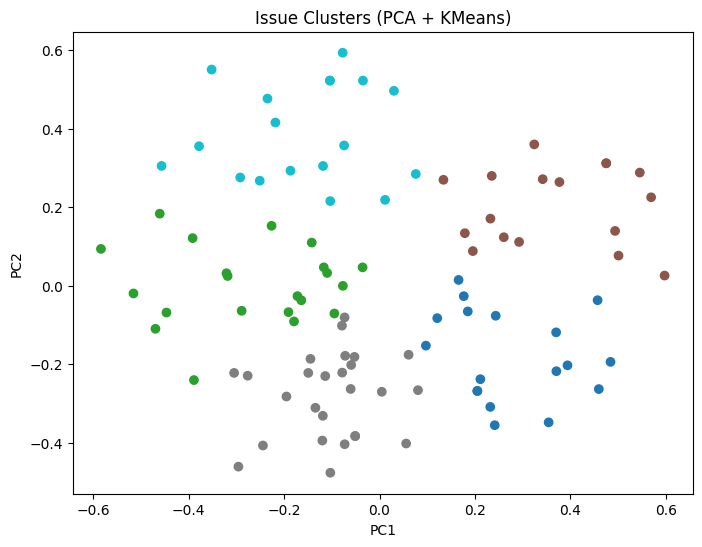

In [24]:
# 6. 시각화 (PCA + KMeans)
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 임베딩 행렬
X = list(df["embedding"])

# PCA 2D
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

# KMeans
kmeans = KMeans(n_clusters=5, random_state=42).fit(X_reduced)
labels = kmeans.labels_

# 시각화
plt.figure(figsize=(8,6))
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=labels, cmap="tab10")
plt.title("Issue Clusters (PCA + KMeans)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


클러스터 대표 키워드: {0: ['error', 'when', 'user'], 1: ['api', 'missing', 'translations'], 2: ['not', 'sent', 'are'], 3: ['not', 'when', 'data'], 4: ['button', 'submit', 'overlaps']}


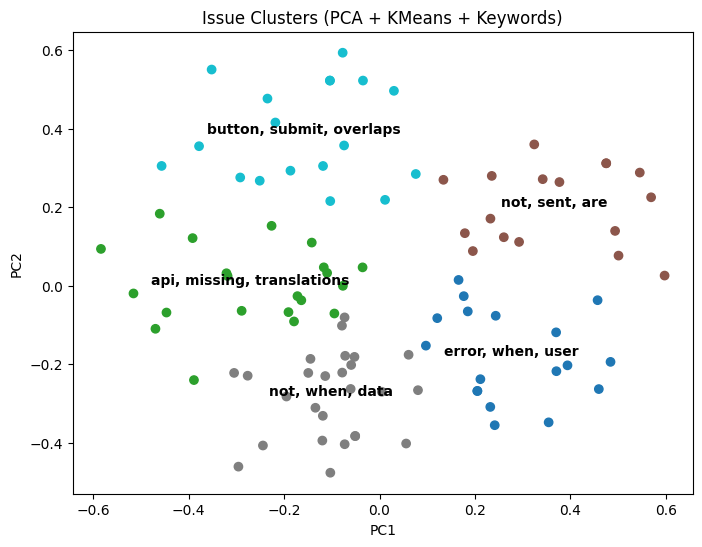

In [ ]:
# 7. 시각화2: 대표 키워드(Top-N 단어) 추출 후 라벨링
import re
from collections import Counter
import numpy as np

# 텍스트 전처리 함수 (간단 버전)
def tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)  # 알파벳/숫자만
    return text.split()

# 불용어 정의 (원하면 nltk stopwords로 확장 가능)
stopwords = set(["the", "and", "is", "to", "in", "of", "for", "on", "a", "an", "with", "by", "from", "at", "this", "that"])

# 각 클러스터별 텍스트 모으기
cluster_texts = {i: [] for i in range(5)}  # n_clusters=5
for idx, label in enumerate(labels):
    tokens = tokenize(df.iloc[idx]["title"] + " " + df.iloc[idx]["description"])
    tokens = [t for t in tokens if t not in stopwords and len(t) > 2]
    cluster_texts[label].extend(tokens)

# 클러스터별 Top-N 키워드 추출
top_keywords = {}
for label, words in cluster_texts.items():
    counter = Counter(words)
    top_keywords[label] = [w for w, _ in counter.most_common(3)]  # 상위 3개

print("클러스터 대표 키워드:", top_keywords)

# 클러스터 중심 계산
centers = kmeans.cluster_centers_

# 시각화 + 라벨
plt.figure(figsize=(8,6))
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=labels, cmap="tab10")

for i, center in enumerate(centers):
    keywords = ", ".join(top_keywords[i])
    plt.text(center[0], center[1], keywords, fontsize=10, weight="bold", ha="center")

plt.title("Issue Clusters (PCA + KMeans + Keywords)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
